In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv("../Merging/Merged_Data.csv")
data.head(5)

,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,total-consumption,total-consumption-units,...,SLP,STP,VISIB,WDSP,MXSPD,GUST,MAX,MIN,PRCP,SNDP
0,2023-08-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,922648.0,MMBtu per Mcf,...,1014.561290,983.287097,8.909677,5.854839,12.848387,400.861290,81.670968,58.432258,0.138065,999.900000
1,2023-03-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,592926.0,MMBtu per Mcf,...,1017.906452,952.787097,8.435484,8.370968,15.396774,213.812903,46.774194,27.229032,0.097742,710.458065
2,2022-04-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,909054.0,MMBtu per Mcf,...,1015.526667,983.276667,9.073333,9.273333,16.643333,123.983333,57.620000,35.900000,0.130333,999.900000
3,2023-10-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,547826.0,MMBtu per Mcf,...,1015.554839,983.629032,9.222581,6.670968,12.351613,369.432258,63.596774,43.464516,0.153871,999.900000
4,2022-08-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,1004884.0,MMBtu per Mcf,...,1016.296774,985.109677,9.448387,5.664516,12.803226,433.454839,84.222581,60.877419,0.201290,999.900000


In [3]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2020-01-01']

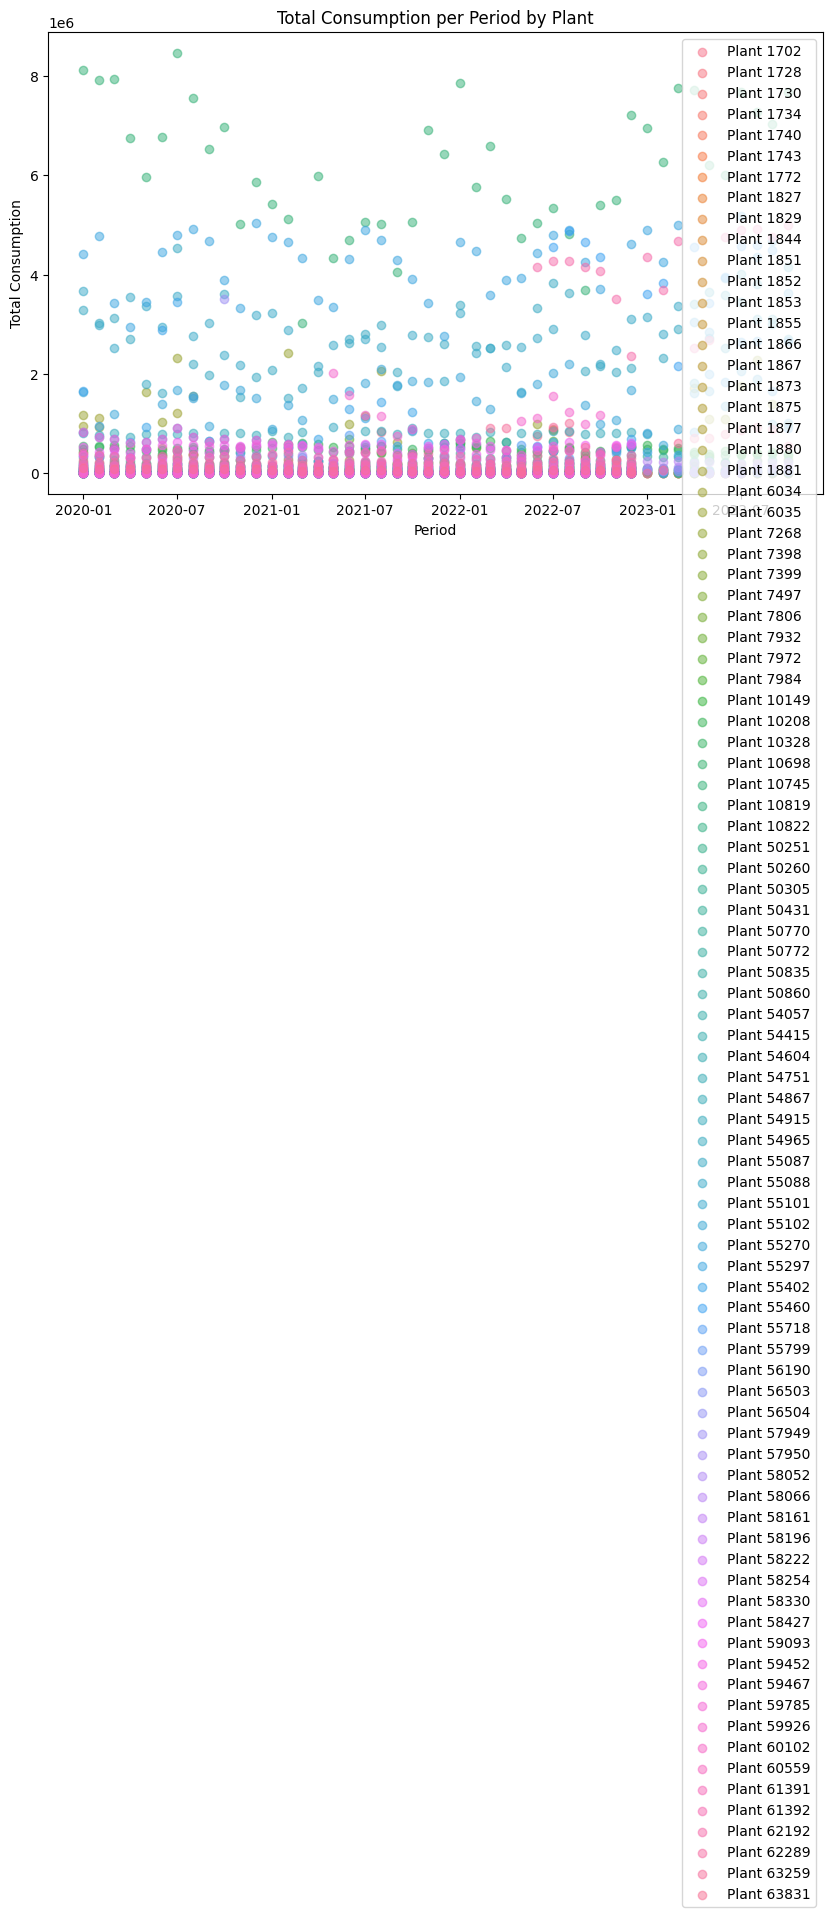

In [4]:

scatter_data = data[['plantCode', 'total-consumption','period']]

grouped_data = scatter_data.groupby('plantCode')['total-consumption'].sum()

palette = sns.color_palette("husl", n_colors=len(grouped_data))

# Scatterplot with different colors for each plant
plt.figure(figsize=(10, 6))
for plant, color in zip(grouped_data.index, palette):
    plant_data = scatter_data[scatter_data['plantCode'] == plant]
    plt.scatter(plant_data['period'], plant_data['total-consumption'], label=f'Plant {plant}', color=color, alpha=0.5)

plt.title('Total Consumption per Period by Plant')
plt.xlabel('Period')
plt.ylabel('Total Consumption')
plt.legend()
plt.show()


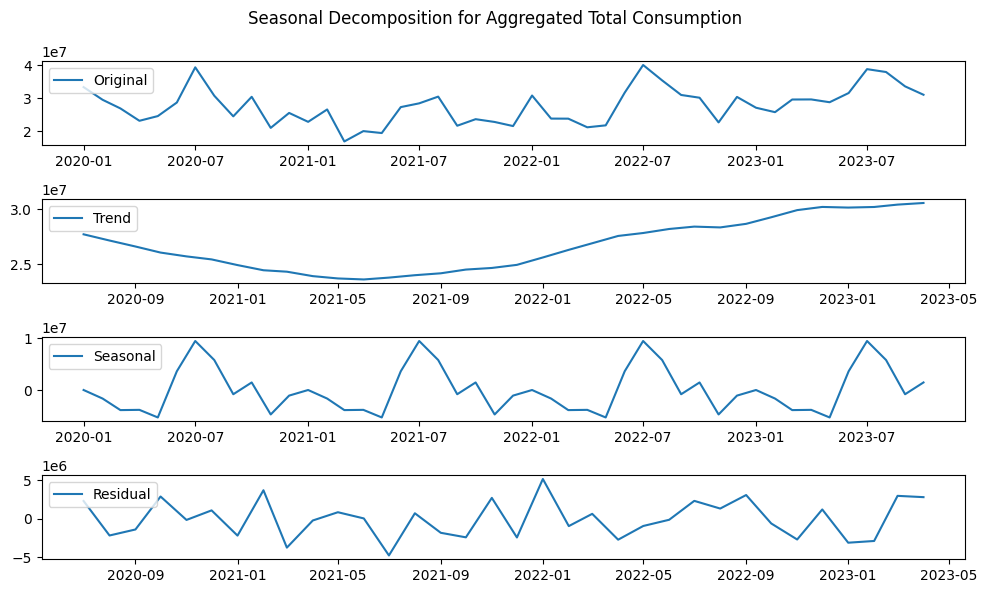

In [5]:
data['period'] = pd.to_datetime(data['period'])


aggregated_data = data.groupby('period')['total-consumption'].sum().reset_index()
aggregated_data.set_index('period', inplace=True)
result = seasonal_decompose(aggregated_data['total-consumption'], model='additive', period=12)


trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the decomposed components for aggregated total consumption
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(aggregated_data['total-consumption'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.suptitle("Seasonal Decomposition for Aggregated Total Consumption")
plt.tight_layout()
plt.show()

In [6]:
# Add linear regression

# Extract features and target variable
X = data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
y = data['total-consumption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 772766783662.2562
R-squared: 0.013355231016322633


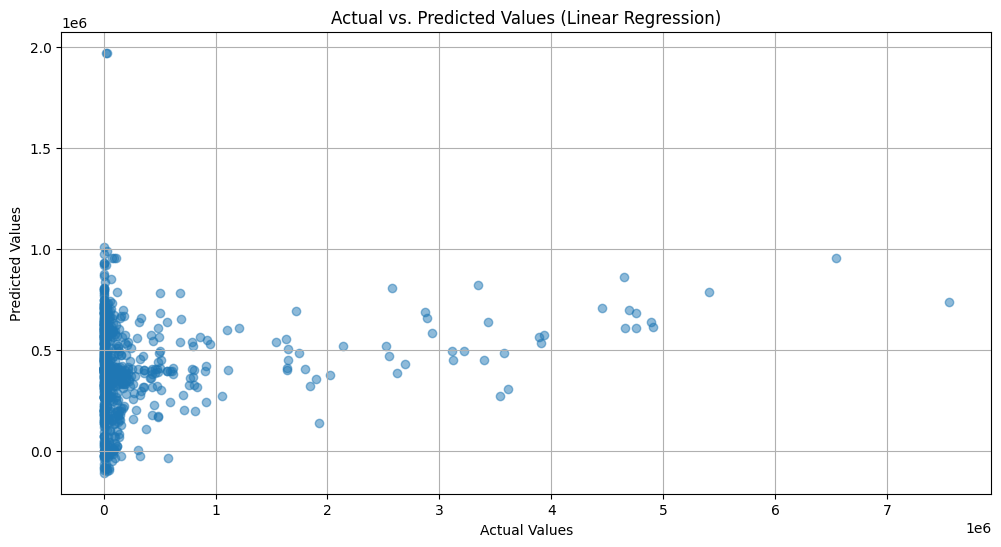

In [7]:

# Scatter plot for actual vs. predicted values (Linear Regression)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

In [8]:
# Create polynomial features (degree=2 for quadratic features)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Split the polynomial features into training and testing sets
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Fit the linear regression model on the polynomial features
model.fit(X_poly_train, y_train)

# Make predictions on the test set with polynomial features
y_poly_pred = model.predict(X_poly_test)

# Evaluate the polynomial regression model
mse_poly = mean_squared_error(y_test, y_poly_pred)
r2_poly = r2_score(y_test, y_poly_pred)

print(f'Mean Squared Error (Polynomial): {mse_poly}')
print(f'R-squared (Polynomial): {r2_poly}')

Mean Squared Error (Polynomial): 808350140324.2797
R-squared (Polynomial): -0.032076500077349746


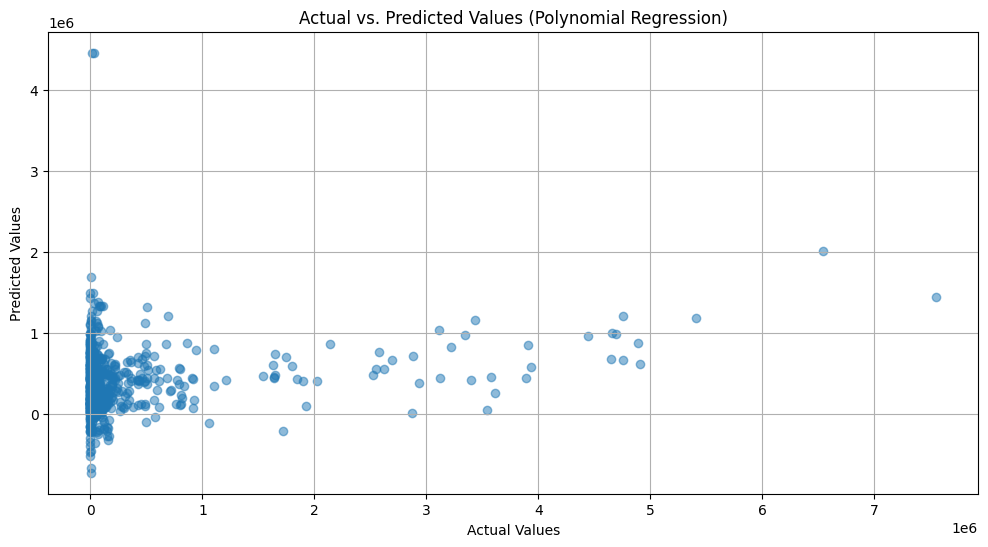

In [9]:

# Scatter plot for actual vs. predicted values (Polynomial Regression)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_poly_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values (Polynomial Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

Clearly, linear and polynomial regression are not appropriate for capturing the underlying patterns in this data, given there is a periodic component to it, and that the R squared values are very low

In [10]:
X = data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
y = data['total-consumption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 729089611838.7865
R-squared: 0.0691208953987894


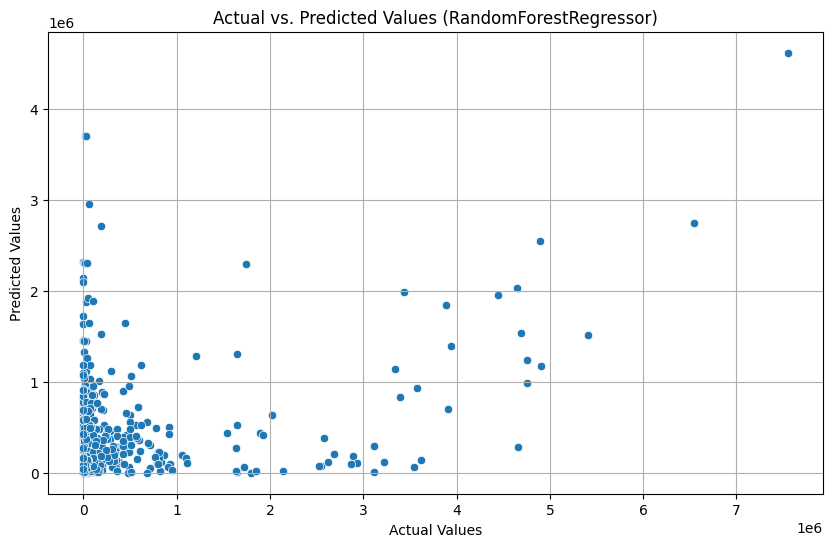

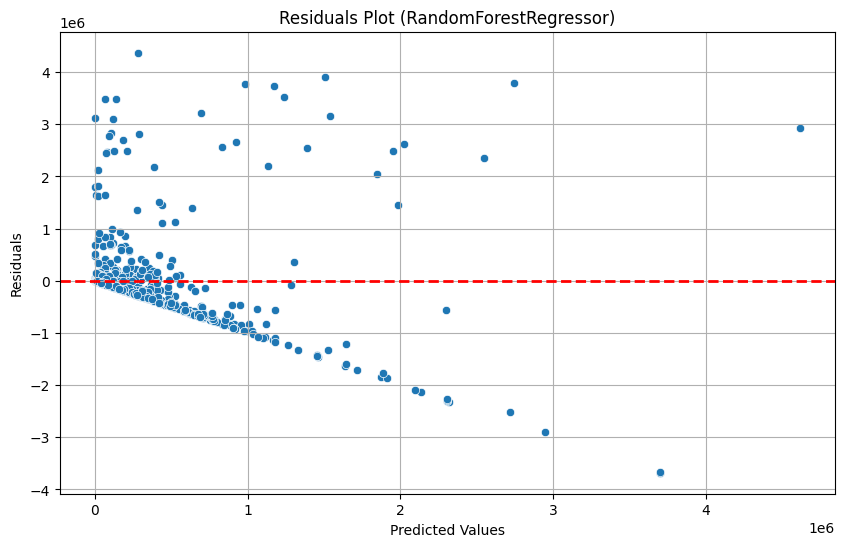

In [11]:
# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Values (RandomForestRegressor)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Visualize the residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.title('Residuals Plot (RandomForestRegressor)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Clearly, there is some trend to the residuals. So an important feature may be missing from the data - or a more advanced/nonlinear model needs to be used. (support vector machine/neural network)

PCA, feature importance, ARIMA